# Global settings

## Imports

In [22]:
import os
import pickle
import datetime
import torch
import random

import pandas as pd
import numpy as np
import plotly.graph_objects as go

from plotly.subplots import make_subplots
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, TensorDataset

from slim_gsgp.datasets.data_loader import *
from slim_gsgp.main_gp import gp


## Settings

In [23]:
seed = 1111
np.random.seed(seed)
random.seed(seed)


In [24]:
train_color = 'blue'
test_color = 'orange'


<br />

## Data simulation

<br />

In addition to the real datasets, simulated data can be a good approach for exploring the algorithms. As an example, following equation generates a dataset with three features ($x_1, x_2, x_3$) that are used to generate the target values ($f(X)$ with some randomness from a Normal distribution($N(0, 3)$):

$$
f(X) = x_1^2 + x_2^2 + x_3^2 + x_1 x_2 x_3 + N(0, 3)
$$


In [25]:
n_samples = 100

feature_1 = np.random.uniform(-10, 10, size=n_samples)
feature_2 = np.random.normal(0, 5, size=n_samples)
feature_3 = np.random.beta(2, 5, size=n_samples) * 20
noise = np.random.normal(0, 3, size=n_samples)

target = (
    feature_1**2 + feature_2**2 + feature_3**2 + 
    feature_1 * feature_2 * feature_3 +
    np.exp(feature_1) +
    noise
)

df = pd.DataFrame({
    'feature_1': feature_1,
    'feature_2': feature_2,
    'feature_3': feature_3,
    'target': target
})

df.head()


,feature_1,feature_2,feature_3,target
0,-8.089016,0.092495,6.982330,108.049532
1,8.500074,-0.449601,0.728967,4986.110745
2,-3.128532,1.238981,7.831148,47.735888
3,-3.790461,0.953761,6.539151,34.137138
4,-9.959803,8.269482,0.094512,157.426576


# Cross-validation object

In [26]:
cv = KFold(n_splits=10, random_state=seed, shuffle=True)


<hr />

# Exploring the slim_gsgp library


To begin exploring the slim_gsgp library, the first recommended resource is the official documentation: [Slim Documentation](https://slim-library.readthedocs.io/en/latest/).

Reading through the source code is also highly informative. _How should you navigate the slim_gsgp source code?_

<br />

<center>
    <img src='slim_framework.png' width=650 />
    <br />
    Figure 01. Overvoew of the slim_gsgp framwork.
</center>

- To run an algorithm, use the method named after the algorithm in its **main script (MAIN module in Figure 01)**. For example, to explore GP, open the main GP script: [https://github.com/DALabNOVA/slim/blob/main/slim_gsgp/main_gp.py](https://github.com/DALabNOVA/slim/blob/main/slim_gsgp/main_gp.py).
- This main method **instantiates an object of the algorithm's class (ALGORITHMS module in Figure 01)**. The class implementation can be found in the file named after the algorithm. For GP, see: [https://github.com/DALabNOVA/slim/blob/main/slim_gsgp/algorithms/GP/gp.py](https://github.com/DALabNOVA/slim/blob/main/slim_gsgp/algorithms/GP/gp.py).
- Finally, it can be helpful to inspect the **configuration file (CONFIG module in Figure 01)** for the algorithm. These files contain, for example, the default hyperparameter settings. For GP, refer to: [https://github.com/DALabNOVA/slim/blob/main/slim_gsgp/config/gp_config.py](https://github.com/DALabNOVA/slim/blob/main/slim_gsgp/config/gp_config.py).

##### These steps are also recommended for the other algorithms of the library.

<br />

##### _How to extend the library (implement your own methods or modify it?_
You can either create a branch on the library github repository or download the source codes and work locally. Check the **Developer tutorial** for instructions on how to modify the library: [https://github.com/DALabNOVA/slim/blob/main/CONTRIBUTING.md](https://github.com/DALabNOVA/slim/blob/main/CONTRIBUTING.md).

<br />

<hr />

# GP


When solving a symbolic regression problem with GP, it is a good practice to start by defining the problem instance and the search space. This is what it is being done in the next cells.

## Step 1: Problem Instance definition

- `X` and `y`: which dataset will be used?
- `fitnesss_function`: the fitness function that will be used to measure the algorithm learning.
- `minimization`: is this a minimization problem?


In [27]:
# DATASET = 'syn'
DATASET = 'boston'
# DATASET = 'bike' # https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset

if DATASET == 'syn':
    X = torch.tensor(df.values[:, :3], dtype=torch.float32)
    y = torch.tensor(df.values[:, 3], dtype=torch.float32)
    DATASET_NAME = 'Synthetic'
elif DATASET == 'boston':
    X, y = load_boston(X_y=True)
    DATASET_NAME = 'Boston'
elif DATASET == 'bike':
    X, y = load_bike_sharing(X_y=True)
    # X = X[:, :11]
    DATASET_NAME = 'Bike'
    
FITNESS_FUNCTION = 'rmse'
MINIMIZATION = True


In [28]:
data_cv = [[train_ix, test_ix] for train_ix, test_ix in cv.split(X, y)][0]

# Train and test split
X_train_tensor = X[data_cv[0], :]
y_train_tensor = y[data_cv[0]]
X_val_tensor = X[data_cv[1], :]
y_val_tensor = y[data_cv[1]]

[X_train_tensor.shape, y_train_tensor.shape, X_val_tensor.shape, y_val_tensor.shape]


[torch.Size([455, 13]),
 torch.Size([455]),
 torch.Size([51, 13]),
 torch.Size([51])]

## Step 2: Search space definition

- `initializer`: how new random trees are initialized. See [`slim_gsgp` initializers](https://github.com/DALabNOVA/slim/blob/main/slim_gsgp/initializers/initializers.py);
- `tree_constants`: the constants to be used in the terminal set;
- `tree_functions`: the function set (tree internal nodes);
- `prob_const`: the probability for choosing constants instead of dataset features on tree terminals;
- `init_depth`: max depth for tree initialisation;
- `max_depth`: max depth of trees during algorithm evolution.


In [29]:
INITIALIZER = 'grow'
TREE_CONSTANTS = [random.uniform(0, 1) for _ in range(9)]+[ -1.]
TREE_FUNCTIONS = ['add', 'subtract']
PROB_CONSTANT = 0.9
MAX_INIT_DEPTH = 4
MAX_DEPTH = 7


In [30]:
TREE_CONSTANTS

# [0.21760077176688164,
#  0.3443807346030824,
#  0.6422536234699076,
#  0.36413206493253214,
#  0.08358916437841302,
#  0.5040914040192876,
#  0.18743462930144428,
#  0.8842252761132199,
#  0.33821341140965044,
#  -1.0]

[0.21760077176688164,
 0.3443807346030824,
 0.6422536234699076,
 0.36413206493253214,
 0.08358916437841302,
 0.5040914040192876,
 0.18743462930144428,
 0.8842252761132199,
 0.33821341140965044,
 -1.0]

## Step 3: GP Instance

It is library-dependent. On `slim_gsgp`, the following customization options are available:

- `pop_size`: the size of the population of candidate solutions.
- `p_xo`: the probability of applying the cross-over genetic operator to candidate solutions.
- `elitism`: should the elite(s) be preserved at each generation?
- `n_elits`: if using elitism, how many solutions should be kept?
- Selection method. Only tournament selection in available on `slim_gsgp` library, as this is the most commonly used. It requires the definition of the `tournament_size` hyperparameter: **how many solutions should participate in the tournament of tournament selection?**


In [31]:
POP_SIZE = 50
P_XO = 0.9
ELISTISM = True
N_ELITES = 1
TOURNAMENT_SIZE = 2


## Step 4: Solve settings

In [32]:
GENERATIONS = 30
VERBOSE = 1

# Log level 2
# -----------
# 0  - Algorithm
# 1  - Instance ID
# 2  - Dataset
# 3  - Seed
# 4  - Generation
# 5  - Fitness
# 6  - Running time
# 7  - Population nodes
# 8  - Test fitness
# 9  - Elite nodes
# 10 - Genotype diversity: niche entropy
# 11 - Phenotype diversity: sd(pop.fit)
# 12 - Log level
LOG_LEVEL = 2
LOG_DIR = './log/PC2/'
LOG_PATH = LOG_DIR+'gp_'+DATASET_NAME+'.csv'

if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR)

if os.path.exists(LOG_PATH):
    os.remove(LOG_PATH)

print(f'Total evaluations: {POP_SIZE*GENERATIONS}\n')


Total evaluations: 1500



## Solve 

In [33]:
model = gp(
    # ---
    # Search Space
    init_depth=MAX_INIT_DEPTH,
    max_depth=MAX_DEPTH,
    tree_constants=TREE_CONSTANTS,
    tree_functions=TREE_FUNCTIONS,
    prob_const = PROB_CONSTANT,
    # --
    # Problem Instance
    X_train=X_train_tensor, y_train=y_train_tensor, 
    X_test=X_val_tensor, y_test=y_val_tensor,
    dataset_name=DATASET_NAME,
    fitness_function=FITNESS_FUNCTION,
    minimization=MINIMIZATION,
    # --
    # GP instance 
    pop_size=POP_SIZE,
    p_xo = P_XO,
    initializer=INITIALIZER,
    tournament_size = TOURNAMENT_SIZE,
    # ---
    # Solve settings
    n_iter=GENERATIONS,
    elitism=ELISTISM,
    n_elites=N_ELITES,
    test_elite=True,
    log_path=LOG_PATH,
    log_level=LOG_LEVEL,
    verbose=VERBOSE,
    n_jobs=1,
    seed=2
)


Verbose Reporter
-----------------------------------------------------------------------------------------------------------------------------------------
|         Dataset         |  Generation  |     Train Fitness     |       Test Fitness       |        Timing          |      Nodes       |
-----------------------------------------------------------------------------------------------------------------------------------------
|     Boston              |       0      |   11.484875679016113  |   6.650751113891602      |   0.009980201721191406 |      3           |
|     Boston              |       1      |   11.484875679016113  |   6.650751113891602      |   0.006000995635986328 |      3           |
|     Boston              |       2      |   11.39140510559082   |   6.601835250854492      |   0.006013631820678711 |      3           |
|     Boston              |       3      |   10.974627494812012  |   6.5472798347473145     |   0.007995843887329102 |      7           |
|     Boston     

In [34]:
pd.read_csv(LOG_PATH, header=None).head()
# 0  - Algorithm
# 1  - Instance ID
# 2  - Dataset
# 3  - Seed
# 4  - Generation
# 5  - Fitness
# 6  - Running time
# 7  - Population nodes
# 8  - Test fitness
# 9  - Elite nodes
# 10 - niche entropy
# 11 - sd(pop.fit)
# 12 - Log level


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,StandardGP,d5541e48-67b1-11f0-abb9-14f6d876cbf8,Boston,2,0,11.484876,0.009980,182.0,6.650751,3,0.0,3.237301,2
1,StandardGP,d5541e48-67b1-11f0-abb9-14f6d876cbf8,Boston,2,1,11.484876,0.006001,182.0,6.650751,3,0.0,4.656191,2
2,StandardGP,d5541e48-67b1-11f0-abb9-14f6d876cbf8,Boston,2,2,11.391405,0.006014,190.0,6.601835,3,0.0,5.144790,2
3,StandardGP,d5541e48-67b1-11f0-abb9-14f6d876cbf8,Boston,2,3,10.974627,0.007996,202.0,6.547280,7,0.0,4.885240,2
4,StandardGP,d5541e48-67b1-11f0-abb9-14f6d876cbf8,Boston,2,4,10.974627,0.007004,202.0,6.547280,7,0.0,5.137612,2


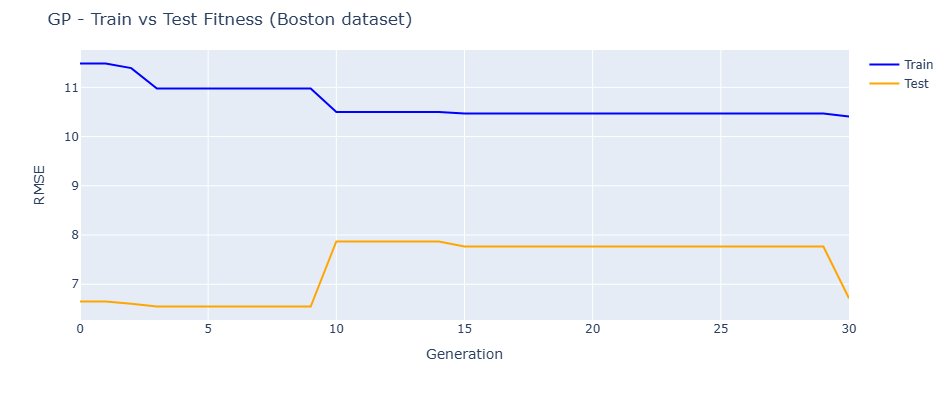

In [35]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=pd.read_csv(LOG_PATH, header=None).iloc[:,5].values, 
                         mode='lines', name='Train', line=dict(color=train_color)))
fig.add_trace(go.Scatter(y=pd.read_csv(LOG_PATH, header=None).iloc[:,8].values, 
                         mode='lines', name='Test', line=dict(color=test_color)))
fig.update_layout(
    height=400, width=800, 
    margin=dict(t=50),
    yaxis_range=[0,None],
    title_text='GP - Train vs Test Fitness ('+DATASET_NAME+' dataset)',
    xaxis_title='Generation', yaxis_title='RMSE'
)
fig.update_yaxes(range=[0, None])
fig.show()


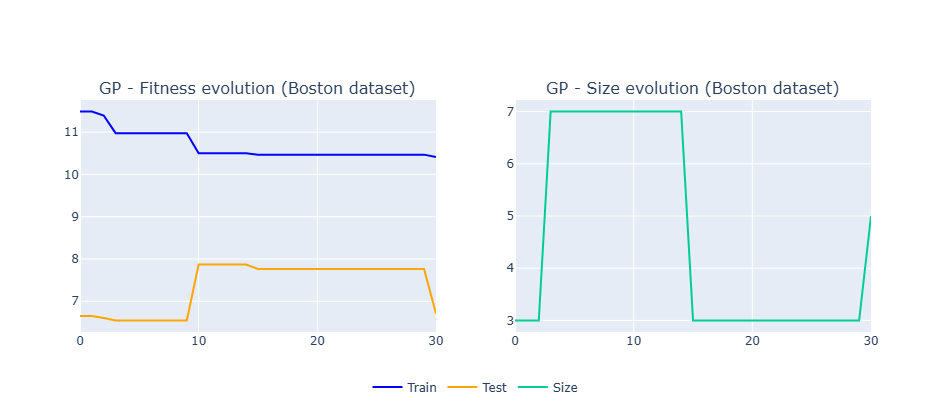

In [36]:
from plotly.subplots import make_subplots
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('GP - Fitness evolution ('+DATASET_NAME+' dataset)', 'GP - Size evolution ('+DATASET_NAME+' dataset)')
)

fig.add_trace(go.Scatter(y=pd.read_csv(LOG_PATH, header=None).iloc[:,5].values, 
                         mode='lines', name='Train', line=dict(color=train_color)), row=1, col=1)
fig.add_trace(go.Scatter(y=pd.read_csv(LOG_PATH, header=None).iloc[:,8].values, 
                         mode='lines', name='Test', line=dict(color=test_color)), row=1, col=1)
fig.add_trace(go.Scatter(y=pd.read_csv(LOG_PATH, header=None).iloc[:,9].values, 
                         mode='lines', name='Size'), row=1, col=2)
fig.update_layout(
    width=1000,
    height=400, 
    showlegend=True,
    yaxis_range=[0,None],
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=-0.3,
        xanchor='center',
        x=0.5
    )
)
fig.show()


In [37]:
model.print_tree_representation()
# model.node_count


add(
  x10
  add(
    x7
    constant_0.5040914040192876
  )
)



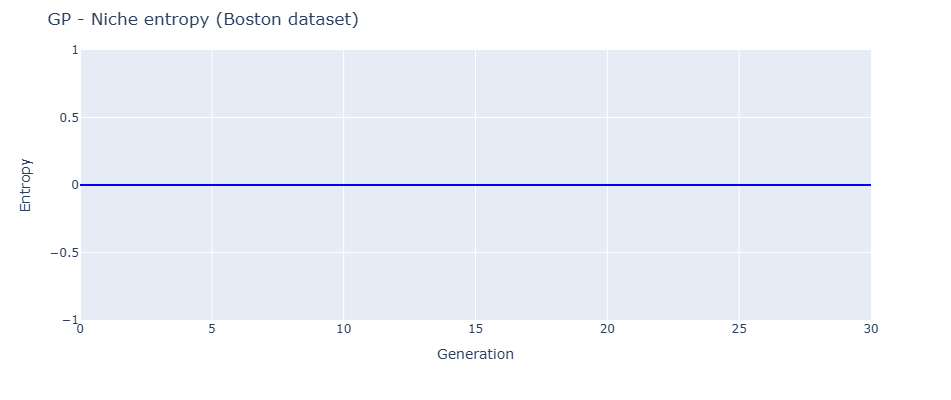

In [38]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=pd.read_csv(LOG_PATH, header=None).iloc[:,10].values, 
                         mode='lines', name='Train', line=dict(color=train_color)))
fig.update_layout(
    height=400, width=800, 
    margin=dict(t=50),
    title_text='GP - Niche entropy ('+DATASET_NAME+' dataset)',
    yaxis_range=[0,None],
    xaxis_title='Generation', yaxis_title='Entropy'
)
fig.show()


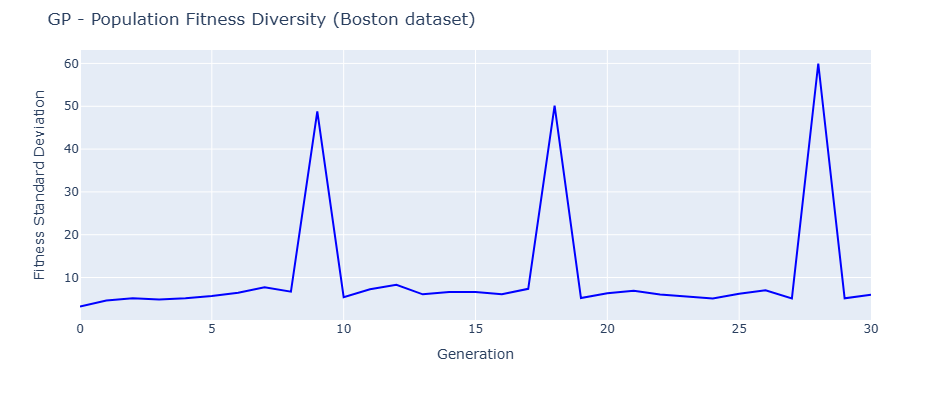

In [39]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=pd.read_csv(LOG_PATH, header=None).iloc[:,11].values, 
                         mode='lines', name='Train', line=dict(color=train_color)))
fig.update_layout(
    height=400, width=800, 
    margin=dict(t=50),
    yaxis_range=[0,None],
    title_text='GP - Population Fitness Diversity ('+DATASET_NAME+' dataset)',
    xaxis_title='Generation', yaxis_title='Fitness Standard Deviation'
)
fig.show()


In [40]:
model.predict(X_val_tensor)


tensor([25.2663, 26.0027, 25.9037, 25.2639, 23.5514, 27.0226, 27.4296, 23.2156,
        24.9048, 24.9048, 23.7835, 22.3700, 22.3191, 21.9993, 23.6151, 21.0633,
        21.8618, 16.8221, 16.9405, 17.4875, 17.4666, 21.4741, 22.9791, 22.7567,
        22.0521, 23.4402, 27.6596, 27.4306, 27.0008, 15.5829, 24.4213, 24.6445,
        24.8252, 25.5163, 25.5163, 26.9394, 28.9962, 23.4268, 22.0621, 22.8719,
        22.1937, 22.1295, 22.1588, 22.6137, 23.0199, 22.9021, 23.0723, 23.1399,
        24.0358, 22.5027, 22.5968])

In [41]:
y_val_tensor


tensor([28.7000, 23.1000, 15.6000, 13.5000, 24.7000, 16.0000, 22.2000, 19.4000,
        28.0000, 24.8000, 23.9000, 25.0000, 20.6000, 28.4000, 19.5000, 19.3000,
        22.0000, 21.5000, 13.1000, 25.0000, 22.3000, 24.1000, 20.0000, 22.4000,
        25.1000, 20.1000, 24.3000, 26.2000, 24.4000, 31.0000, 22.3000, 23.8000,
        20.4000, 20.6000, 19.0000, 23.1000, 22.9000, 22.7000, 13.3000, 23.2000,
         5.0000,  5.0000, 17.2000,  8.3000, 14.3000, 12.6000, 16.1000, 14.1000,
        23.7000, 19.7000, 18.3000])

In [42]:
[model.fitness, model.test_fitness]

[tensor(10.4094), tensor(6.7129)]

<br />
<hr />

# Excercises (not graded)

- Experiment new datasets.
- Run the hyperparameters tunning for the Boston or synthetic data.
    
<br />
